In [1]:
import numpy as np
import sklearn
from scipy.stats.stats import pearsonr
import pickle
import pandas as pd
from scipy.cluster.vq import whiten
from sklearn import cluster
from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn import decomposition
import matplotlib.pyplot as plt
import urllib
import tensorflow as tf
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from numpy import genfromtxt
from random import shuffle
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10535746447210153685
]


In [2]:
print(tf.__version__)

1.4.0


# Get the folder names and length

In [3]:
def GetName(path):
    Folder = []
    r = []
    Subfolder = []
    full_path = []
    count_list = []
    for folder in os.listdir(path):
        count = 0
        Folder.append(folder)
        for subfolder in os.listdir(path+'/'+folder):
            Subfolder.append(subfolder)
            for files in os.listdir(path+'/'+folder+'/'+subfolder):
                if os.path.splitext(files)[1] == ".pts":
                    r.append(files) 
                    full_path.append(folder+'/'+subfolder+'/'+files)
                    count += 1
        count_list.append(count)
    return Folder, Subfolder, r, full_path, count_list

In [7]:
# Get what we need for each FOLD (1,2,3,4,5) for two people involved

# for FOLD_1
path = r"C:/Users/pinouche/Downloads/FOLD_1/"
Folders_Fold1, Subfolders_Fold1, Files_Fold1, Full_path_Fold1, count_list_FOLD1 = GetName(path)

In [12]:
# FOLD 2
path = r"C:/Users/pinouche/Downloads/FOLD_2/"
Folders_Fold2, Subfolders_Fold2, Files_Fold2, Full_path_Fold2, count_list_FOLD2 = GetName(path)

In [8]:
# FOLD 3
path = r"C:/Users/pinouche/Downloads/FOLD_3/"
Folders_Fold3, Subfolders_Fold3, Files_Fold3, Full_path_Fold3, count_list_FOLD3 = GetName(path)

In [9]:
# FOLD 4
path = r"C:/Users/pinouche/Downloads/FOLD_4/"
Folders_Fold4, Subfolders_Fold4, Files_Fold4, Full_path_Fold4, count_list_FOLD4 = GetName(path)

In [10]:
#FOLD 5
path = r"C:/Users/pinouche/Downloads/FOLD_5/"
Folders_Fold5, Subfolders_Fold5, Files_Fold5, Full_path_Fold5, count_list_FOLD5 = GetName(path)

In [13]:
# concat the folders above and print some information about the shapes

Folders_full = np.concatenate([Folders_Fold1, Folders_Fold2, Folders_Fold3, Folders_Fold4, Folders_Fold5])
Count_full = np.concatenate([count_list_FOLD1, count_list_FOLD2, count_list_FOLD3, count_list_FOLD4, count_list_FOLD5])
Full_path_full = np.concatenate([Full_path_Fold1, Full_path_Fold2, Full_path_Fold3, Full_path_Fold4, Full_path_Fold5])
print([Folders_full.shape, Count_full.shape, Full_path_full.shape])

[(73,), (73,), (213072,)]


# Load the data

In [428]:
# Retrieve the data for FOLD1

data_x = pickle.load( open( "data_x.p", "rb" ))
print(data_x.shape)

(106536, 196)


In [15]:
data_x_68 = pickle.load( open( "data_x_68.p", "rb" ))
print(data_x_68.shape)

(106536, 272)


In [16]:
# Retrieve the annotations

annotation_vector_Two = pickle.load( open( "annotation_vector_Two.p", "rb" ))
print(annotation_vector_Two.shape)

(73,)


# Put the 68 point data into the right form 

In [17]:
def ConcatFulldata(data):
    #new_data = np.zeros((1,68*4))
    count = 0
    counter = 0
    listt = []
    for element in Count_full:
        element2 = int(element/2)
        for index in range(element2):
            concat = np.reshape(np.concatenate([Full_data_x[count+index,:],Full_data_x[count+element2+index,:]], axis = 0), (1,68*4))
            listt.append(concat)
            counter += 1
            if counter % 5000 == 0:
                print(str(counter)+"/106536 done")
        count += element
    listt = np.asarray(listt)
    return(listt)

# scale the data

In [429]:
# get the participants separated

from sklearn import preprocessing

data_participant1 = data_x[:,:98]
data_participant2 = data_x[:,98:]
participant1_scaled = preprocessing.scale(data_participant1)
participant2_scaled = preprocessing.scale(data_participant2)
data_x = preprocessing.scale(data_x)

C:\Users\pinouche\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype <U7 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


# Smooth the response data

In [430]:
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

def SmoothResponse(response_list = annotation_vector_Two):
    length = len(annotation_vector_Two)
    gauss_kernel_40 = Gaussian1DKernel(25)
    gauss_kernel_50 = Gaussian1DKernel(50)
    gauss_kernel_75 = Gaussian1DKernel(75)
    gauss_kernel_100 = Gaussian1DKernel(100)
    annotation_RBF40 = []
    annotation_RBF50 = []
    annotation_RBF75 = []
    annotation_RBF100 = []
    for index in range(length):
        response_list[index] = np.reshape(response_list[index], (response_list[index].shape[0],))
        
        Ann40 = convolve(response_list[index], gauss_kernel_40)
        Ann40[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann40 = np.reshape(Ann40, (response_list[index].shape[0],1))
        
        Ann50 = convolve(response_list[index], gauss_kernel_50)
        Ann50[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann50 = np.reshape(Ann50, (response_list[index].shape[0],1))
        
        Ann75 = convolve(response_list[index], gauss_kernel_75)
        Ann75[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann75 = np.reshape(Ann75, (response_list[index].shape[0],1))
        
        Ann100 = convolve(response_list[index], gauss_kernel_100)
        Ann100[response_list[index].shape[0]-100:,] = response_list[index][response_list[index].shape[0]-100:]
        Ann100 = np.reshape(Ann100, (response_list[index].shape[0],1))
    
        annotation_RBF40.append(Ann40)
        annotation_RBF50.append(Ann50)
        annotation_RBF75.append(Ann75)
        annotation_RBF100.append(Ann100)
           
    return annotation_RBF40, annotation_RBF50, annotation_RBF75, annotation_RBF100 

In [431]:
annotation_RBF40, annotation_RBF50, annotation_RBF75, annotation_RBF100 = SmoothResponse()
print([len(annotation_RBF40), len(annotation_RBF50), len(annotation_RBF75), len(annotation_RBF100)])
print([annotation_RBF40[0].shape, annotation_RBF50[0].shape, annotation_RBF75[0].shape, annotation_RBF100[0].shape])

[73, 73, 73, 73]
[(11155, 1), (11155, 1), (11155, 1), (11155, 1)]


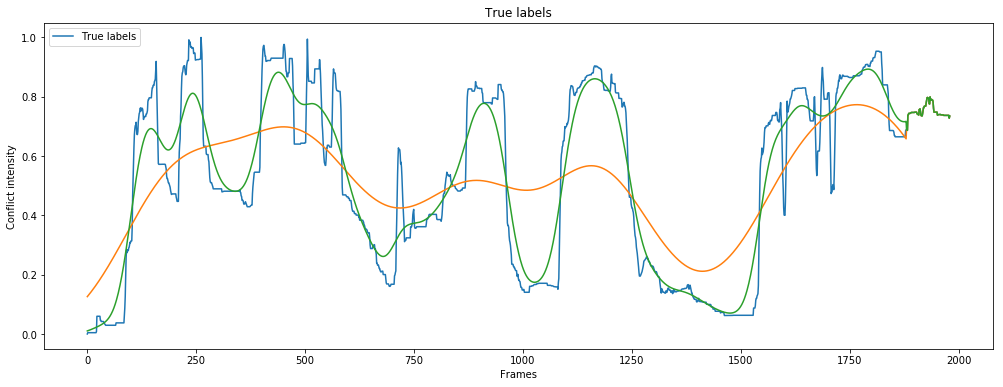

In [432]:
# Plot a few video sequences to see if smoothing is justified

fig = plt.figure(figsize=(17, 6))
plt.plot(annotation_vector_Two[1])
plt.plot(annotation_RBF100[1])
plt.plot(annotation_RBF40[1])
plt.title('True labels')
plt.ylabel('Conflict intensity')
plt.xlabel('Frames')
plt.legend(['True labels'], loc='upper left')
plt.show()

# Prepare data to feed into NN

In [433]:
def Makelist(data,Count):
    Count = Count/2
    list_data = []
    ball = 0
    for index in range(0,len(Count)):
        list_data.append(data[ball:(ball+int(Count[index])),:])
        ball += int(Count[index])
    return(np.asarray(list_data))

In [434]:
list_data_x = Makelist(data_x, Count_full)

In [435]:
# put the things into FOLDS

def DoFOLDS(list_data, annotation_list_smooth, annotation_list, num_folder1=len(Folders_Fold1), num_folder2=len(Folders_Fold2), num_folder3=len(Folders_Fold3), num_folder4=len(Folders_Fold4), num_folder5=len(Folders_Fold5)):
    Fold1 = []
    Fold2 = []
    Fold3 = []
    Fold4 = []
    Fold5 = []
    Fold1_y_smooth = []
    Fold2_y_smooth = []
    Fold3_y_smooth = []
    Fold4_y_smooth = []
    Fold5_y_smooth = []
    Fold1_y = []
    Fold2_y = []
    Fold3_y = []
    Fold4_y = []
    Fold5_y = []
    
    for index in range(num_folder1):
        Fold1.append(list_data[index])
        Fold1_y_smooth.append(annotation_list_smooth[index])
        Fold1_y.append(annotation_list[index])
    for index in range(num_folder1, num_folder1+num_folder2):
        Fold2.append(list_data[index])
        Fold2_y_smooth.append(annotation_list_smooth[index])
        Fold2_y.append(annotation_list[index])
    for index in range(num_folder1+num_folder2,num_folder1+num_folder2+num_folder3):
        Fold3.append(list_data[index])
        Fold3_y_smooth.append(annotation_list_smooth[index])
        Fold3_y.append(annotation_list[index])
    for index in range(num_folder1+num_folder2+num_folder3,num_folder1+num_folder2+num_folder3+num_folder4):
        Fold4.append(list_data[index])
        Fold4_y.append(annotation_list[index])
        Fold4_y_smooth.append(annotation_list_smooth[index])
    for index in range(num_folder1+num_folder2+num_folder3+num_folder4,num_folder1+num_folder2+num_folder3+num_folder4+num_folder5):
        Fold5.append(list_data[index])
        Fold5_y_smooth.append(annotation_list_smooth[index])
        Fold5_y.append(annotation_list[index])
    
    assert (len(Fold1)+len(Fold2)+len(Fold3)+len(Fold4)+len(Fold5)) == 73
    
    return Fold1, Fold2, Fold3, Fold4, Fold5, Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth, Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y

Fold1, Fold2, Fold3, Fold4, Fold5, Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth, Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y = DoFOLDS(list_data_x, annotation_RBF40, annotation_vector_Two)

In [436]:
#Test number must be either 1,2,3,4,5

def MakeTrainValTest(test_number, Fold1=Fold1, Fold2=Fold2, Fold3=Fold3, Fold4=Fold4, Fold5=Fold5, Fold1_y=Fold1_y, Fold2_y=Fold2_y, Fold3_y=Fold3_y, Fold4_y=Fold4_y, Fold5_y=Fold5_y, Fold1_y_smooth=Fold1_y_smooth, Fold2_y_smooth=Fold2_y_smooth, Fold3_y_smooth=Fold3_y_smooth, Fold4_y_smooth=Fold4_y_smooth, Fold5_y_smooth=Fold5_y_smooth):
    list_Folds = list([Fold1, Fold2, Fold3, Fold4, Fold5])
    list_Folds_y = list([Fold1_y, Fold2_y, Fold3_y, Fold4_y, Fold5_y])
    list_Folds_y_smooth = list([Fold1_y_smooth, Fold2_y_smooth, Fold3_y_smooth, Fold4_y_smooth, Fold5_y_smooth])
    number_val_test = []
    Train_list = []
    Val_list = []
    Test_list = []
    Train_list_y = []
    Val_list_y = []
    Test_list_y = []
    length = 0
    
    Test_list = list_Folds[test_number-1]
    Test_list_y = list_Folds_y[test_number-1]
    number_val_test.append(test_number-1)
    
    if(test_number == 1):
        Val_list = list_Folds[4]
        Val_list_y = list_Folds_y[4]
        number_val_test.append(4)
    else:
        Val_list = list_Folds[test_number-2]
        Val_list_y = list_Folds_y[test_number-2]
        number_val_test.append(test_number-2)
    
    for index in range(5):
        length = len(list_Folds[index])
        if(index != number_val_test[0] and index != number_val_test[1]):
            for index2 in range(length):
                Train_list.append(list_Folds[index][index2])
                Train_list_y.append(list_Folds_y_smooth[index][index2])       
    
    return Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y 

In [437]:
Train_list, Val_list, Test_list, Train_list_y, Val_list_y, Test_list_y = MakeTrainValTest(1)

In [438]:
# Make the Val_list_y of interest from above in 3 classes (low, medium, high) of conflict

def MakeOneHot(val_list_y):
    new_list = []
    a = np.array([1,0])
    b = np.array([0,1])
    #c = np.array([0,0,1])
    for index in range(len(val_list_y)):
        for element in val_list_y[index]:
            if(element < 1/2):
                new_list.append(a)
            elif(element >= 1/2):
                new_list.append(b)
            #elif(element >= 2/3):
            #    new_list.append(c)
    return(new_list)

In [439]:
# function to compute the class accuracy

def ComputeAccuracy(True_classes_list, predicted_classes_list):
    accuracy = 0
    assert len(True_classes_list) == len(predicted_classes_list)
    for index in range(len(True_classes_list)):
        if(all (True_classes_list[index] == predicted_classes_list[index])):
            accuracy += 1
    accuracy /= len(predicted_classes_list)
    return(accuracy)

In [440]:
def MakeOneHotTrain(train_list_y):
    new_list = []
    final_list = []
    a = np.array([1,0,0])
    b = np.array([0,1,0])
    c = np.array([0,0,1])
    length = 0
    count = 0
    for index in range(len(train_list_y)):
        length = len(train_list_y[index])
        for element in train_list_y[index]:
            if(element < 1/3):
                new_list.append(a)
            elif(element >= 1/3 and element < 2/3):
                new_list.append(b)
            elif(element >= 2/3):
                new_list.append(c)
        final_list.append(np.asarray(new_list[count:count+length]))
        count += length
    return(final_list)

In [441]:
def exclude_nan(x,y):

    idx = logical_not(logical_or(isnan(x), isnan(y)))
    x = x[idx]
    y = y[idx]
    n = len(x)
    return [x, y, n]

def compute_icc(x, y):

    if all(x == y):
        return 1

    [x, y, n] = exclude_nan(x,y)

    ## Need at least 3 data points to compute this
    if n < 1:
        return nan

    Sx = sum(x); Sy = sum(y);
    Sxx = sum(x*x); Sxy = sum( (x+y)**2 )/2; Syy = sum(y*y)

    fact = ((Sx + Sy)**2)/(n*2)
    SS_tot = Sxx + Syy - fact
    SS_among = Sxy - fact
    SS_error = SS_tot - SS_among

    MS_error = SS_error/n
    MS_among = SS_among/n

    ICC = (MS_among - MS_error) / (MS_among + MS_error)

    return ICC

In [442]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def SoftMaxFlatten(crocker):
    finalList=[]
    for element in crocker:
        for sub_element in element:
            smax=softmax(sub_element)
            b = np.zeros_like(smax)
            b[np.where(smax==np.max(smax))] = 1
            finalList.append(b)
            
    return finalList

In [443]:
def PearsonCor(pred_val_list, val_list_y):
    pearson_cor = 0
    assert len(pred_val_list) == len(val_list_y)
    for index in range(len(pred_val_list)):
        pearson_cor += pearsonr(np.reshape(pred_val_list[index], (pred_val_list[index].shape[0],)), np.reshape(val_list_y[index], (val_list_y[index].shape[0],)))[0]
        print(pearson_cor)
    return(pearson_cor/len(pred_val_list))  

In [444]:
def ManyToOne(x_seq, y_seq, window_size, val_boolean):
    list_x = []
    list_y = []
    list_x_shuffled = []
    list_y_shuffled = []
    assert len(x_seq) == len(y_seq)
    lenght_new_seq = len(x_seq)-window_size+1
    
    for index in range(lenght_new_seq):
        list_x.append(x_seq[index:window_size+index,:])
        list_y.append(y_seq[window_size-1+index])
    
    if(val_boolean == 0):
        indices = list(range(lenght_new_seq))
        shuffle(indices)
    
        for element in indices:
            list_x_shuffled.append(list_x[element])
            list_y_shuffled.append(list_y[element])
            
    elif(val_boolean == 1):
        list_x_shuffled = list_x
        list_y_shuffled = list_y
        
    return list_x_shuffled, list_y_shuffled  

In [445]:
def ManyToMany(x_seq, y_seq, window_size, val_boolean):
    list_x = []
    list_y = []
    list_x_shuffled = []
    list_y_shuffled = []
    assert len(x_seq) == len(y_seq)
    lenght_new_seq = len(x_seq)-window_size+1
    
    for index in range(lenght_new_seq):
        list_x.append(x_seq[index:window_size+index,:])
        list_y.append(y_seq[index:window_size+index])
    
    if(val_boolean == 0):
        indices = list(range(lenght_new_seq))
        shuffle(indices)
    
        for element in indices:
            list_x_shuffled.append(list_x[element])
            list_y_shuffled.append(list_y[element])
            
    elif(val_boolean == 1):
        list_x_shuffled = list_x
        list_y_shuffled = list_y
        
    return list_x_shuffled, list_y_shuffled 

# Stacked (many to one) LSTM with "attention"

In [98]:
timesteps_1 = 25
window_size = timesteps_1
batch_size = 1
n_epochs = 10

# Hidden layer for the LSTMs
LSTM1 = 256
LSTM2 = 128
# Hidden size for the fully connected layer
FC1 = 64

num_input = 272
epsilon = 0.001
beta = 0.1
learning_rate = 0.000001

In [99]:
def LSTM(train_x, train_y, val_x, val_y, learning_rate=learning_rate, batch_size=batch_size,  n_epochs=n_epochs, num_input=num_input, timesteps_1=timesteps_1, hidden_size = LSTM1, hidden_size1 = LSTM2, hidden_size2 = FC1, window_size = window_size):


    with tf.variable_scope('data'):
        prob = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [batch_size, timesteps_1, num_input], dtype = tf.float32, name = "input")
        X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [batch_size,1], dtype = tf.float32, name = "label_annotation")
        
    with tf.variable_scope('lstm_cell_1'):
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size, hidden_size1]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs, lstm_state =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=X,dtype=tf.float32)
        lstm_outputs = tf.stack(tf.squeeze(lstm_outputs))
        
        batch_mean1, batch_var1 = tf.nn.moments(lstm_outputs,[0])
        scale1 = tf.Variable(tf.ones([hidden_size1]))
        beta1 = tf.Variable(tf.zeros([hidden_size1]))
        BN1 = tf.nn.batch_normalization(lstm_outputs,batch_mean1, batch_var1, beta1, scale1, epsilon) 
        lstm_outputs = tf.nn.dropout(BN1, prob)

    ##################
        
    with tf.variable_scope('Fully_connected_Layer1'):
        
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size1, hidden_size2], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_relu = tf.matmul(BN1, W_hidden)
        batch_mean2, batch_var2 = tf.nn.moments(hidden_relu,[0])
        scale2 = tf.Variable(tf.ones([hidden_size2]))
        beta2 = tf.Variable(tf.zeros([hidden_size2]))
        BN2 = tf.nn.batch_normalization(hidden_relu,batch_mean2, batch_var2, beta2, scale2, epsilon)
        BN2 = tf.nn.relu(BN2)
              
    with tf.variable_scope('Attention_weight'):
        W_attention = tf.Variable(tf.random_normal(shape = [hidden_size2, 1], stddev = 0.1), name = "weights_attention", trainable = True)
        b_linear = tf.Variable(tf.zeros([window_size, 1]), name="bias", trainable = True)
        attention_score = tf.matmul(BN2, W_attention) + b_linear
        attention_score = tf.nn.softmax(attention_score)
  
    with tf.variable_scope('Alignment_step'):
        hidden_weighted = tf.multiply(lstm_outputs, attention_score)
        
        W_hidden2 = tf.Variable(tf.random_normal(shape = [hidden_size1, hidden_size2], stddev = 0.1), name = "weights_hidden2", trainable = True)
        hidden_relu2 = tf.matmul(hidden_weighted, W_hidden2)
        batch_mean3, batch_var3 = tf.nn.moments(hidden_relu2,[0])
        scale3 = tf.Variable(tf.ones([hidden_size2]))
        beta3 = tf.Variable(tf.zeros([hidden_size2]))
        BN3 = tf.nn.batch_normalization(hidden_relu2,batch_mean3, batch_var3, beta3, scale3, epsilon)
        BN3 = tf.nn.relu(BN3)
             
    with tf.variable_scope('loss'):
        
        W_linear = tf.Variable(tf.random_normal(shape = [hidden_size2, 1], stddev = 0.1), name = "weights_linear", trainable = True)
        b_linear = tf.Variable(tf.zeros([window_size, 1]), name="bias_linear", trainable = True)
        pre_logits = tf.matmul(BN3, W_linear)+b_linear
        pre_logits = tf.reshape(pre_logits, (1,window_size))
        final_weights = tf.Variable(tf.random_normal(shape = [window_size, 1], stddev = 0.1), name = "weights_final", trainable = True)
        logits = tf.matmul(pre_logits, final_weights)
        
        loss =  tf.losses.mean_squared_error(predictions = logits, labels = y)
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("bias" in tf_var.name or "bias_linear" in tf_var.name))
        loss = tf.reduce_mean(loss+l2)
        
    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    print(sess.run(tf.shape(X_or)))
    print(sess.run(tf.shape(X)))
    print(sess.run(tf.shape(BN1)))
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    #saver = tf.train.Saver()
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    val_loss = []
    train_loss_list = []
    attention_score_list = []
    for i in range(1, n_epochs+1):
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToOne(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = np.reshape(list_x[index], (batch_size, window_size, num_input))
                Y_batch = np.reshape(list_y[index], (1,1))
                
                _, Loss = sess.run([train_op, loss], feed_dict = {X_or: X_batch, y: Y_batch, prob: 0.6})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
        train_loss_list.append(train_loss_sum)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 3 == 0 or i == 10):
           
            total_loss_list = []
            list_list_val_y = []
            pred_val = []        
            for index in range(len(val_x)):
                total_loss = 0
                list_x_val, list_y_val = ManyToOne(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    #pred_val = []
                    X_batch = np.reshape(list_x_val[index1], (batch_size, window_size, num_input))
                    Y_batch = np.reshape(list_y_val[index1], (1,1))
                    attention_weights, loss_batch, logits_batch = sess.run([attention_score, loss, logits], feed_dict = {X_or: X_batch, y: Y_batch, prob: 1})
                    pred_val.append(logits_batch)
                    attention_score_list.append(attention_weights)
                
                    total_loss += loss_batch
                
                total_loss /= len(list_x_val)
                total_loss_list.append(total_loss)
                list_list_val_y.append(list_y_val)
            val_loss_sum = sum(total_loss_list)/len(val_x)
            
            pred_val_classes = MakeOneHot(pred_val)
            Val_list_y_classes = MakeOneHot(list_list_val_y)
            accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            
            print("Step: " + str(i) + " MSE val loss {0}".format(val_loss_sum) + " MSE training loss " + str(train_loss_sum))
            print("The total of good classification is: " + str(accuracy))
            val_loss.append(val_loss_sum)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)*2
    # Implement early stopping later for the best method 
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))

    sess.close()
    tf.reset_default_graph()
    writer.close()

    return lowest_loss, min_index, val_loss, train_loss_list, pred_val, attention_score_list

In [101]:
lowest_loss, min_index, val_loss, train_loss_list, pred_val, attention_score_list = LSTM(Train_list, Train_list_y, Val_list, Val_list_y)

# Stacked many to many LSTM 

In [546]:
tf.reset_default_graph()

In [547]:
timesteps_1 = 25
window_size = timesteps_1
batch_size = 1
n_epochs = 10

# Hidden layer for the LSTMs
LSTM1 = 64
LSTM2 = 64
# Hidden size for the fully connected layer
FC1 = 32

num_input = 196
epsilon = 0.001
beta = 0.02
learning_rate = 0.000001

In [548]:
def LSTM(train_x, train_y, val_x, val_y, learning_rate=learning_rate, batch_size=batch_size,  n_epochs=n_epochs, num_input=num_input, timesteps_1=timesteps_1, hidden_size = LSTM1, hidden_size1 = LSTM2, hidden_size2 = FC1, window_size = window_size):


    with tf.variable_scope('data'):
        alpha = tf.placeholder_with_default(1.0, shape=())
        prob = tf.placeholder_with_default(1.0, shape=())
        #prob2 = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [batch_size, timesteps_1, num_input], dtype = tf.float32, name = "input")
        
        X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [window_size,1], dtype = tf.float32, name = "label_annotation")
        
    with tf.variable_scope('lstm_cell_1'):
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size, hidden_size1]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs, lstm_state =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=X,dtype=tf.float32)
        lstm_outputs = tf.stack(tf.squeeze(lstm_outputs))
        
        batch_mean1, batch_var1 = tf.nn.moments(lstm_outputs,[0])
        scale1 = tf.Variable(tf.ones([hidden_size1]))
        beta1 = tf.Variable(tf.zeros([hidden_size1]))
        BN1 = tf.nn.batch_normalization(lstm_outputs,batch_mean1, batch_var1, beta1, scale1, epsilon) 
        #BN1 = tf.nn.dropout(BN1, prob, noise_shape = [1,hidden_size1])
        

    ##################
        
    with tf.variable_scope('Fully_connected_Layer1'):
        W_hidden = tf.Variable(tf.random_normal(shape = [hidden_size1, hidden_size2], stddev = 0.1), name = "weights_hidden", trainable = True)
        hidden_relu = tf.matmul(tf.squeeze(BN1), W_hidden)
        
        batch_mean2, batch_var2 = tf.nn.moments(hidden_relu,[0])
        scale2 = tf.Variable(tf.ones([hidden_size2]))
        beta2 = tf.Variable(tf.zeros([hidden_size2]))
        BN2 = tf.nn.batch_normalization(hidden_relu,batch_mean2, batch_var2, beta2, scale2, epsilon) 
        BN2 = tf.nn.relu(BN2)
        BN2 = tf.nn.dropout(BN2, prob, noise_shape = [1,hidden_size2])
            
  
    with tf.variable_scope('loss'):
        W_hidden2 = tf.Variable(tf.random_normal(shape = [hidden_size2, 1], stddev = 0.1), name = "linear_layer", trainable = True)
        b_hidden_2 = tf.Variable(tf.zeros([window_size, 1]), name="bias", trainable = True)
        logits_all = tf.nn.relu(tf.matmul(BN2, W_hidden2)+b_hidden_2)
        logits_others = logits_all[:window_size-1,:]
        logits_all =  tf.reshape(logits_all, (1,window_size))

        W_all = tf.Variable(tf.random_normal(shape = [window_size, 1], stddev = 0.1), name = "linear_others", trainable = True)
        logit_main = tf.matmul(logits_all,W_all)
          
        loss_other =  tf.losses.mean_squared_error(predictions = logits_others, labels = y[:window_size-1])
        loss_main = tf.losses.mean_squared_error(predictions = logit_main, labels = y[window_size-1:])
        loss = loss_other + alpha * loss_main
        regularized_variables = list([tf.trainable_variables()[6],tf.trainable_variables()[7],tf.trainable_variables()[8],tf.trainable_variables()[9],tf.trainable_variables()[11]])
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in regularized_variables)
        loss += l2
        
    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    #saver = tf.train.Saver()
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    val_loss = []
    train_loss_list = []
    for i in range(1, n_epochs+1):
        pred_val = []
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToMany(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = np.reshape(list_x[index], (1, window_size, num_input))
                Y_batch = np.reshape(list_y[index], (window_size,1))
                
                _, Loss = sess.run([train_op, loss_main], feed_dict = {X_or: X_batch, y: Y_batch, alpha: 2, prob: 0.8})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
        train_loss_list.append(train_loss_sum)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):

            list_list_val_y = []
            pred_val = []        
            loss_main_list = []
            for index in range(len(val_x)):
                #total_loss = 0
                total_loss_main = 0
                list_x_val, list_y_val = ManyToMany(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    
                    X_batch = np.reshape(list_x_val[index1], (1, window_size, num_input))
                    Y_batch = np.reshape(list_y_val[index1], (window_size,1))
                    loss_batch, logits_batch = sess.run([loss_main, logit_main], feed_dict = {X_or: X_batch, y: Y_batch, alpha: 2, prob: 1})
                    pred_val.append(logits_batch[0])
                    list_list_val_y.append(Y_batch[window_size-1])
                
               
                    total_loss_main += loss_batch
                
                total_loss_main /= len(list_x_val)
                loss_main_list.append(total_loss_main)

            main_sum_loss =  sum(loss_main_list)/len(val_x)

            #pred_val_classes = MakeOneHot(pred_val)
            #Val_list_y_classes = MakeOneHot(list_list_val_y)
            #accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            
            print("Step: " + str(i) + " MSE val loss is " + str(main_sum_loss)+ " MSE training loss " + str(train_loss_sum))
            pearson = pearsonr(np.reshape(np.asarray(pred_val), (len(pred_val),)), np.reshape(np.asarray(list_list_val_y),(len(pred_val),)))
            print("The correlation is: " + str(pearson))
            val_loss.append(main_sum_loss)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)
  
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))

    sess.close()
    tf.reset_default_graph()
    writer.close()

    return lowest_loss, min_index, val_loss, train_loss_list, pred_val

In [550]:
# This model works

lowest_loss, min_index, val_loss, train_loss_list, pred_val = LSTM(Train_list, Train_list_y, Val_list, Val_list_y)

# Attention mechanism

In [595]:
tf.reset_default_graph()

In [596]:
timesteps_1 = 25
window_size = timesteps_1
batch_size = 1
n_epochs = 10

# Hidden layer for the LSTMs
LSTM1 = 64
LSTM2 = 64
# Hidden size for the fully connected layer
FC1 = 32

num_input = 196
epsilon = 0.001
beta = 0.02
learning_rate = 0.000001

In [597]:
def Attention(train_x, train_y, val_x, val_y, learning_rate=learning_rate, batch_size=batch_size,  n_epochs=n_epochs, num_input=num_input, timesteps_1=timesteps_1, hidden_size = LSTM1, hidden_size2 = FC1, window_size = window_size):


    with tf.variable_scope('data'):
        prob = tf.placeholder_with_default(1.0, shape=())
        #prob2 = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [batch_size, timesteps_1, num_input], dtype = tf.float32, name = "input")
        #XX = tf.nn.dropout(X_or, prob2, noise_shape=[batch_size, 1, num_input])
        X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [window_size,1], dtype = tf.float32, name = "label_annotation")
        logits = tf.zeros((1,1), tf.float32)
        
    with tf.variable_scope('lstm_cell_encoder'):
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size, hidden_size]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs, lstm_state =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=X,dtype=tf.float32)
        concat_lstm_outputs = tf.stack(tf.squeeze(lstm_outputs))
        
        batch_mean1, batch_var1 = tf.nn.moments(concat_lstm_outputs,[0])
        scale1 = tf.Variable(tf.ones([hidden_size]))
        beta1 = tf.Variable(tf.zeros([hidden_size]))
        BN1 = tf.nn.batch_normalization(concat_lstm_outputs, batch_mean1, batch_var1, beta1, scale1, epsilon) 
        BN1 = tf.nn.dropout(BN1, prob)
        last_encoder_state = lstm_state[-1]
        initial_input = tf.unstack(tf.zeros(shape=(1,1,hidden_size2)))

     
    rnn_decoder_cell = tf.nn.rnn_cell.LSTMCell(hidden_size, reuse = tf.AUTO_REUSE)
    
    for index in range(window_size):   
        with tf.variable_scope('lstm_cell_decoder', reuse = tf.AUTO_REUSE):
            output_decoder, state_decoder = tf.nn.static_rnn(rnn_decoder_cell, initial_input, initial_state=last_encoder_state, dtype=tf.float32) 
    
            batch_mean2, batch_var2 = tf.nn.moments(output_decoder[-1],[0])
            scale2 = tf.Variable(tf.ones([hidden_size]))
            beta2 = tf.Variable(tf.zeros([hidden_size]))
            BN2 = tf.nn.batch_normalization(output_decoder[-1],batch_mean2, batch_var2, beta2, scale2, epsilon) 
            BN2 = tf.nn.relu(BN2)
            BN2 = tf.nn.dropout(BN2, prob)
                
                
            # Compute the score for source output vector
            scores = tf.matmul(concat
                               _lstm_outputs, tf.reshape(BN2,(hidden_size,1)))
            attention_coef = tf.nn.softmax(scores)
            context_vector = tf.reduce_sum(tf.multiply(BN1, tf.reshape(attention_coef, (window_size, 1))),0)
            context_vector = tf.reshape(context_vector, (1,hidden_size))

            # compute the tilda hidden state \tilde{h}_t=tanh(W[c_t, h_t]+b_t)
            concat_context = tf.concat([context_vector, output_decoder[-1]], axis = 1)
            
            W_tilde = tf.get_variable("weights_tilde", initializer=tf.random_normal(shape = [hidden_size*2, hidden_size2], stddev = 0.1), trainable = True)
            b_tilde = tf.get_variable("bias_tilde",initializer = tf.zeros([1, hidden_size2]), trainable = True)
          
            hidden_tilde = tf.nn.tanh(tf.matmul(concat_context, W_tilde)+b_tilde) # hidden_tilde is [1*64]

            # update for next time step
            initial_input = tf.unstack(tf.reshape(hidden_tilde, (1,1,hidden_size2)))
            last_encoder_state = state_decoder
           
            # predict the target
            W_target = tf.get_variable("weights_target", initializer=tf.random_normal(shape = [hidden_size2, 1], stddev = 0.1), trainable = True)
         
            
            logit = tf.matmul(hidden_tilde, W_target)
            logits = tf.concat([logits, logit], axis = 0)
            
    logits = logits[1:]
    
    var_regularize = list([tf.trainable_variables()[10], tf.trainable_variables()[12]])
    
    ##################
  
    with tf.variable_scope('loss'):
    
        
        loss_other =  tf.losses.mean_squared_error(predictions = logits[:window_size-1], labels = y[:window_size-1])
        loss_main = tf.losses.mean_squared_error(predictions = logits[window_size-1:], labels = y[window_size-1:])
        loss = loss_other+loss_main
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in var_regularize)
        loss += l2


    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    #saver = tf.train.Saver()
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    attention_list = []
    val_loss = []
    train_loss_list = []
    for i in range(1, n_epochs+1):
        pred_val = []
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToMany(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = np.reshape(list_x[index], (1, window_size, num_input))
                Y_batch = np.reshape(list_y[index], (window_size,1))
                
                _, Loss = sess.run([train_op, loss_main], feed_dict = {X_or: X_batch, y: Y_batch, prob: 0.7})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
        train_loss_list.append(train_loss_sum)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):

            list_list_val_y = []
            pred_val = []        
            loss_main_list = []
            for index in range(len(val_x)):
                #total_loss = 0
                total_loss_main = 0
                list_x_val, list_y_val = ManyToMany(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    
                    X_batch = np.reshape(list_x_val[index1], (1, window_size, num_input))
                    Y_batch = np.reshape(list_y_val[index1], (window_size,1))
                    loss_batch, logits_batch, coefficients = sess.run([loss_main, logits, attention_coef], feed_dict = {X_or: X_batch, y: Y_batch, prob: 1})
                    pred_val.append(logits_batch[window_size-1])
                    list_list_val_y.append(Y_batch[window_size-1])
                    if(i == n_epochs):
                        attention_list.append(coefficients)       
               
                    total_loss_main += loss_batch
                
                total_loss_main /= len(list_x_val)
                loss_main_list.append(total_loss_main)

            main_sum_loss =  sum(loss_main_list)/len(val_x)

            pearson = pearsonr(np.reshape(np.asarray(pred_val), (len(pred_val),)), np.reshape(np.asarray(list_list_val_y),(len(pred_val),)))
            #pred_val_classes = MakeOneHot(pred_val)
            #Val_list_y_classes = MakeOneHot(list_list_val_y)
            #accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            
            print("Step: " + str(i) + " MSE val loss is " + str(main_sum_loss)+ " MSE training loss " + str(train_loss_sum))
            print("The pearson correlation is: " + str(pearson))
            val_loss.append(main_sum_loss)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)
  
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))

    sess.close()
    tf.reset_default_graph()
    writer.close()

    return lowest_loss, min_index, val_loss, train_loss_list, pred_val, list_list_val_y, attention_list

In [598]:
lowest_loss, min_index, val_loss, train_loss_list, pred_val, list_list_val_y, attention_list = Attention(Train_list, Train_list_y, Val_list, Val_list_y)

Epoch 1 done.
Step: 1 MSE val loss is 0.127563303933 MSE training loss 0.282497300804
The pearson correlation is: (-0.018841490915286054, 0.0076186103396113742)
Epoch 2 done.
Step: 2 MSE val loss is 0.134447126176 MSE training loss 0.133778488668
The pearson correlation is: (-0.034818530680702092, 8.122256816499141e-07)
Epoch 3 done.
Step: 3 MSE val loss is 0.11360528689 MSE training loss 0.107370611086
The pearson correlation is: (-0.0466743578361766, 3.7531931608325833e-11)
Epoch 4 done.
Step: 4 MSE val loss is 0.0926421458784 MSE training loss 0.0963848261841
The pearson correlation is: (-0.049425548284337519, 2.4911134062466966e-12)
Epoch 5 done.
Step: 5 MSE val loss is 0.0916616103557 MSE training loss 0.0922427184455
The pearson correlation is: (-0.050212002950448614, 1.116019457659314e-12)
Epoch 6 done.
Step: 6 MSE val loss is 0.0856714693472 MSE training loss 0.0876791827056
The pearson correlation is: (-0.033747314679198476, 1.747989000003919e-06)
Epoch 7 done.
Step: 7 MSE val

# Encoder plus attention decoder

In [610]:
tf.reset_default_graph()

In [611]:
timesteps_1 = 2
window_size = 25
batch_size = window_size
n_epochs = 10

# Hidden layer for the LSTMs
hidden_size_bilstm = 64
hidden_size_mainlstm = 64

LSTM1 = 64
LSTM2 = 64
# Hidden size for the fully connected layer
FC1 = 32

num_input = 98
epsilon = 0.001
beta = 0.02
learning_rate = 0.000001

In [ ]:
def BidirectionalLSTM(train_x, train_y, val_x, val_y,hidden_size_bilstm=hidden_size_bilstm, hidden_size_mainlstm=hidden_size_mainlstm, batch_size = batch_size,  hidden_size = LSTM1, hidden_size2 = FC1, n_epochs=n_epochs, epsilon = epsilon, learning_rate=learning_rate):
    
    with tf.variable_scope('data'):
        alpha = tf.placeholder_with_default(1.0, shape=())
        prob = tf.placeholder_with_default(1.0, shape=())
        X_or = tf.placeholder(shape = [window_size, timesteps_1, num_input], dtype = tf.float32, name = "input")
        X = tf.unstack(X_or, timesteps_1, 1)
        y = tf.placeholder(shape = [window_size,1], dtype = tf.float32, name = "label_annotation")
        logits = tf.zeros((1,1), tf.float32)

    #Bidirectional lstm with different weights
    #with tf.variable_scope('lstm_cell_forward'):
    #    lstm_cell_f = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias= 1.0)
    #with tf.variable_scope('lstm_cell_backward'):
    #    lstm_cell_b = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias = 1.0)
     
    # Bidirectional lstm with shared weights (makes more sense for them to be shared)
    with tf.variable_scope('lstm_cell_bidirectional'):
        lstm_cell_f = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias= 1.0)
    with tf.variable_scope('lstm_cell_bidirectional', reuse=True):
        lstm_cell_b = tf.nn.rnn_cell.BasicLSTMCell(hidden_size_bilstm, forget_bias = 1.0)
     
    with tf.variable_scope("lstm_bidirectional"):
        bi_outputs, _, _ = tf.nn.static_bidirectional_rnn(lstm_cell_f, lstm_cell_b, inputs = X, dtype= tf.float32)
        last_output = bi_outputs[-1]
        
        batch_mean2, batch_var2 = tf.nn.moments(last_output,[0])
        scale2 = tf.Variable(tf.ones([hidden_size_bilstm*2]))
        beta2 = tf.Variable(tf.zeros([hidden_size_bilstm*2]))
        BN2 = tf.nn.batch_normalization(last_output,batch_mean2, batch_var2, beta2, scale2, epsilon) 
        BN2 = tf.nn.dropout(BN2, prob)
        
        BN2 = tf.reshape(BN2, (1, window_size, hidden_size_bilstm*2))
        BN2 = tf.transpose(BN2, [1, 0, 2])
        BN2 = tf.unstack(BN2)
        
    with tf.variable_scope('lstm_cell_encoder'):
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in [hidden_size, hidden_size]]
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        lstm_outputs, lstm_state =  tf.contrib.rnn.static_rnn(cell=multi_rnn_cell,inputs=BN2,dtype=tf.float32)
        concat_lstm_outputs = tf.stack(tf.squeeze(lstm_outputs))
        
        batch_mean1, batch_var1 = tf.nn.moments(concat_lstm_outputs,[0])
        scale1 = tf.Variable(tf.ones([hidden_size]))
        beta1 = tf.Variable(tf.zeros([hidden_size]))
        BN1 = tf.nn.batch_normalization(concat_lstm_outputs, batch_mean1, batch_var1, beta1, scale1, epsilon) 
        BN1 = tf.nn.dropout(BN1, prob)
        last_encoder_state = lstm_state[-1]
        initial_input = tf.unstack(tf.zeros(shape=(1,1,hidden_size2)))

     
    rnn_decoder_cell = tf.nn.rnn_cell.LSTMCell(hidden_size, reuse = tf.AUTO_REUSE)
    
    
    for index in range(window_size):   
        with tf.variable_scope('lstm_cell_decoder', reuse = tf.AUTO_REUSE):
            output_decoder, state_decoder = tf.nn.static_rnn(rnn_decoder_cell, initial_input, initial_state=last_encoder_state, dtype=tf.float32) 
    
            batch_mean3, batch_var3 = tf.nn.moments(output_decoder[-1],[0])
            scale3 = tf.get_variable(name="scale", initializer = tf.ones([hidden_size]))
            beta3 = tf.get_variable(name="beta3", initializer = tf.zeros([hidden_size]))
            BN3 = tf.nn.batch_normalization(output_decoder[-1],batch_mean3, batch_var3, beta3, scale3, epsilon) 
            BN3 = tf.nn.relu(BN3)
            BN3 = tf.nn.dropout(BN3, prob)
                
            # Compute the score for source output vector
            scores = tf.matmul(concat_lstm_outputs, tf.reshape(BN3,(hidden_size,1)))
            attention_coef = tf.nn.softmax(scores)
            context_vector = tf.reduce_sum(tf.multiply(BN1, tf.reshape(attention_coef, (window_size, 1))),0)
            context_vector = tf.reshape(context_vector, (1,hidden_size))

            # compute the tilda hidden state \tilde{h}_t=tanh(W[c_t, h_t]+b_t)
            concat_context = tf.concat([context_vector, output_decoder[-1]], axis = 1)
            
            W_tilde = tf.get_variable("weights_tilde", initializer=tf.random_normal(shape = [hidden_size*2, hidden_size2], stddev = 0.1), trainable = True)
            b_tilde = tf.get_variable("bias_tilde",initializer = tf.zeros([1, hidden_size2]), trainable = True)
          
            hidden_tilde = tf.nn.tanh(tf.matmul(concat_context, W_tilde)+b_tilde) # hidden_tilde is [1*64]

            # update for next time step
            initial_input = tf.unstack(tf.reshape(hidden_tilde, (1,1,hidden_size2)))
            last_encoder_state = state_decoder
           
            # predict the target
            W_target = tf.get_variable("weights_target", initializer=tf.random_normal(shape = [hidden_size2, 1], stddev = 0.1), trainable = True)
         
            
            logit = tf.matmul(hidden_tilde, W_target)
            logits = tf.concat([logits, logit], axis = 0)
            
    logits = logits[1:]
    
    var_regularize = list([tf.trainable_variables()[10], tf.trainable_variables()[12]])
    
    ##################
  
    with tf.variable_scope('loss'):
    
        
        loss_other =  tf.losses.mean_squared_error(predictions = logits[:window_size-1], labels = y[:window_size-1])
        loss_main = tf.losses.mean_squared_error(predictions = logits[window_size-1:], labels = y[window_size-1:])
        loss = loss_other+loss_main
        l2 = beta * sum(tf.nn.l2_loss(tf_var) for tf_var in var_regularize)
        loss += l2


    global_step = tf.Variable(0, trainable=False)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_op = optimizer.minimize(loss)
    

    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    writer = tf.summary.FileWriter('./graphs', sess.graph)
    
    #saver = tf.train.Saver()
    
    #ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/lstm/checkpoint'))

    #if ckpt and ckpt.model_checkpoint_path:
    #    saver.restore(sess, ckpt.model_checkpoint_path)
    
    attention_list = []
    val_loss = []
    train_loss_list = []
    for i in range(1, n_epochs+1):
        pred_val = []
        train_loss_list = []

        indices = list(range(len(train_x)))
        shuffle(indices)
        for index1 in indices:
            train_loss = 0
            list_x, list_y = ManyToMany(train_x[index1], train_y[index1], window_size = window_size, val_boolean = 0)
            
            for index in range(len(list_x)):
                
                X_batch = np.reshape(list_x[index], (1, window_size, num_input))
                Y_batch = np.reshape(list_y[index], (window_size,1))
                
                _, Loss = sess.run([train_op, loss_main], feed_dict = {X_or: X_batch, y: Y_batch, prob: 0.6})
                train_loss += Loss
            train_loss /= len(list_x)
            train_loss_list.append(train_loss)
        
        train_loss_sum = sum(train_loss_list)/len(train_x)
        train_loss_list.append(train_loss_sum)
            
        print('Epoch ' + str(i) + ' done.')
        if(i % 1 == 0):

            list_list_val_y = []
            pred_val = []        
            loss_main_list = []
            for index in range(len(val_x)):
                #total_loss = 0
                total_loss_main = 0
                list_x_val, list_y_val = ManyToMany(val_x[index], val_y[index], window_size = window_size, val_boolean = 1)
                
                for index1 in range(len(list_x_val)):
                    
                    X_batch = np.reshape(list_x_val[index1], (1, window_size, num_input))
                    Y_batch = np.reshape(list_y_val[index1], (window_size,1))
                    loss_batch, logits_batch, coefficients = sess.run([loss_main, logits, attention_coef], feed_dict = {X_or: X_batch, y: Y_batch, prob: 1})
                    pred_val.append(logits_batch[window_size-1])
                    list_list_val_y.append(Y_batch[window_size-1])
                    if(i == n_epochs):
                        attention_list.append(coefficients)       
               
                    total_loss_main += loss_batch
                
                total_loss_main /= len(list_x_val)
                loss_main_list.append(total_loss_main)

            main_sum_loss =  sum(loss_main_list)/len(val_x)

            pearson = pearsonr(np.reshape(np.asarray(pred_val), (len(pred_val),)), np.reshape(np.asarray(list_list_val_y),(len(pred_val),)))
            #pred_val_classes = MakeOneHot(pred_val)
            #Val_list_y_classes = MakeOneHot(list_list_val_y)
            #accuracy = ComputeAccuracy(Val_list_y_classes, pred_val_classes) 
            
            print("Step: " + str(i) + " MSE val loss is " + str(main_sum_loss)+ " MSE training loss " + str(train_loss_sum))
            print("The pearson correlation is: " + str(pearson))
            val_loss.append(main_sum_loss)
            #saver.save(sess, 'checkpoints/lstm/method1', i)

          
    lowest_loss = min(val_loss)
    min_index = (val_loss.index(min(val_loss))+1)
  
    print("The lowest validation loss is at epoch " + str(min_index) + " is: " + str(lowest_loss))

    sess.close()
    tf.reset_default_graph()
    writer.close()

    return lowest_loss, min_index, val_loss, train_loss_list, pred_val, list_list_val_y, attention_list
        
    

In [ ]:
lowest_loss, min_index, val_loss, train_loss_list, pred_val, list_list_val_y, attention_list = BidirectionalLSTM(Train_list, Train_list_y, Val_list, Val_list_y)

# What is random guess?

In [183]:
hot_list = MakeOneHot(Train_list_y)

In [193]:
print(type(hot_list), len(hot_list))

zeros = 0
ones = 0
for element in hot_list:
    if(all(element == [1,0])):
        zeros += 1
    elif(all(element == [0,1])):
        ones += 1

print(zeros, ones)    

<class 'list'> 63263
25974 37289


In [190]:
(37289/63263)*100

58.942825980430904

In [191]:
hot_list_val = MakeOneHot(Val_list_y)

In [192]:
zeros = 0
ones = 0
for element in hot_list_val:
    if(all(element == [1,0])):
        zeros += 1
    elif(all(element == [0,1])):
        ones += 1

print(zeros, ones)    

8565 11877


In [194]:
# If we do random guessing, we would have 58.1 % right

(11877/(8565+11877))*100

58.100968594071034

In [224]:
count = 0
total = 0
summ = 0
for element in Train_list_y:
    for element2 in element:
        total += 1
        summ += element2
        if(element2 < 0.1):
            count += 1

In [225]:
# the mean conflict of training is 0.54
# the mean training for validation is 0.5
print(summ/total)

[ 0.54053263]
